In [46]:
import os
from os.path import isfile, join, isdir
import pandas as pd
from datasets import load_dataset, load_from_disk
import evaluate
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from transformers import pipeline, AutoFeatureExtractor, AutoModelForImageClassification, Trainer, TrainingArguments
import transformers
from torchvision import transforms
from sklearn.ensemble import RandomForestClassifier
import pickle
import numpy as np
from tensorflow.keras.preprocessing import image as tsimage
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import hashlib
from keras.layers import Flatten
from skimage.io import imread
import cv2
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D
import filecmp
import itertools
from sklearn.utils import class_weight
from IPython.display import display
from IPython.display import Image as IPYImage
import torch
from scipy.special import softmax
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.decomposition import PCA, IncrementalPCA
from skimage.feature import local_binary_pattern, hog
from PIL import Image, ImageOps
from sklearn.cluster import KMeans
import seaborn as sns
from skimage import exposure
from skimage.restoration import estimate_sigma
from sklearn.utils import shuffle
import shutil
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16
import fastai
import fastai.vision.all as fav
from transformers_interpret import ImageClassificationExplainer
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [47]:
working_dir = os.getcwd()

first_data_dir = os.path.join(working_dir, "RawData/dataset2/all_images")
second_data_dir = os.path.join(working_dir, "RawData/dataset1")
third_data_dir = os.path.join(working_dir, "RawData/dataset3/chest_xray")

normal_dirs = [
    os.path.join(first_data_dir, "Normal"),
    os.path.join(first_data_dir, "universal_test/Normal"),
    os.path.join(second_data_dir, "NORMAL"),
    os.path.join(third_data_dir, "test/NORMAL"),
    os.path.join(third_data_dir, "val/NORMAL"),
    os.path.join(third_data_dir, "train/NORMAL"),
]
covid_dirs = [
    os.path.join(second_data_dir, "COVID")
]
pneumonia_dirs = [
    os.path.join(first_data_dir, "Pneumonia"),
    os.path.join(first_data_dir, "universal_test/Pneumonia"),
    os.path.join(second_data_dir, "PNEUMONIA"),
    os.path.join(third_data_dir, "test/PNEUMONIA"),
    os.path.join(third_data_dir, "val/PNEUMONIA"),
    os.path.join(third_data_dir, "train/PNEUMONIA"),
]
tuberculosis_dirs = [
    os.path.join(first_data_dir, "Tuberculosis"),
    os.path.join(first_data_dir, "universal_test/Tuberculosis")
]

data = [
    (normal_dirs, "Normal"),
    (covid_dirs, "Covid"),
    (pneumonia_dirs, "Pneumonia"),
    (tuberculosis_dirs, "Tuberculosis"),
]

In [48]:
# Initialize a dictionary to store labeled data
image_data_by_label = {}

# Iterate through the list of paths and their corresponding labels
for image_paths, category in data:
    image_files_for_category = []
    
    # Loop through each path in the list of paths
    for image_path in image_paths:
        files_in_path = [os.path.join(image_path, file_name) for file_name in os.listdir(image_path)]
        # Add the files to the list for the current label
        image_files_for_category.extend(files_in_path)
    
    # Store the list of files in the dictionary with the label as the key
    image_data_by_label[category] = image_files_for_category
    print(f"Discovered {len(image_data_by_label[category])} images for the '{category}' category")

Discovered 12673 images for the 'Normal' category
Discovered 1626 images for the 'Covid' category
Discovered 10318 images for the 'Pneumonia' category
Discovered 1888 images for the 'Tuberculosis' category


In [49]:
def prepare_dataset(file_paths, category_name):
    dataset = pd.DataFrame()
    dataset["file_location"] = file_paths
    dataset["category"] = [category_name for _ in range(len(file_paths))]
    return dataset

final_dataset = pd.DataFrame()
for category_name, file_locations in image_data_by_label.items():
    final_dataset = pd.concat([final_dataset, prepare_dataset(file_locations, category_name)], ignore_index=True)

del image_data_by_label
final_dataset

,file_location,category
0,/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/NORMAL-2552119-0002.jpeg,Normal
1,/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/Normal-1821.png,Normal
2,/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/h3038.png,Normal
3,/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/Normal-2496.png,Normal
4,/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/NORMAL-7298141-0001.jpeg,Normal
...,...,...
26500,/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/universal_test/Tuberculosis/tb0916.png,Tuberculosis
26501,/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/universal_test/Tuberculosis/Tuberculosis-472.png,Tuberculosis
26502,/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/universal_test/Tuberculosis/tb0686.png,Tuberculosis
26503,/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/universal_test/Tuberculosis/Tuberculosis-248.png,Tuberculosis


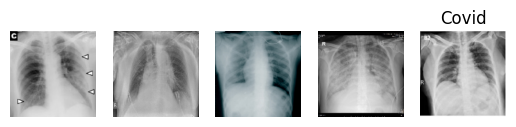

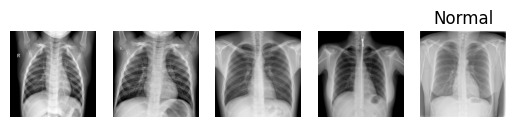

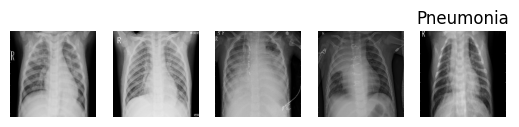

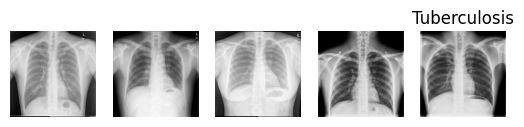

In [50]:
for category_name, category_data in final_dataset.groupby("category"):
    for idx, row in category_data.sample(5).reset_index(drop=True).iterrows():
        img = imread(row["file_location"])
        img = cv2.resize(cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE), (224, 224))
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.title(category_name)
    plt.show()


def get_dataset_number(path):
    dataset_numbers = {first_data_dir: 0, second_data_dir: 1, third_data_dir: 2}
    for key, value in dataset_numbers.items():
        if key in path:
            return value
    return -1

final_dataset['dataset'] = final_dataset['file_location'].apply(lambda path: get_dataset_number(path))

Below cell takes 8-12 minutes to run

In [51]:
def find_unique_files(file_paths):
    """
    Identify and remove duplicate files based on their content using SHA-256 hashing.
    
    Args:
        file_paths (list): List of file paths to process.
    
    Returns:
        tuple: A tuple containing:
            - List of unique file paths.
            - Count of duplicate files found.
    """
    file_hash_dict = {}  # Maps file hashes to their corresponding paths
    duplicate_files = 0   # Counts the number of duplicate files detected

    for file_path in file_paths:
        # Calculate the SHA-256 hash of the file's content
        with open(file_path, 'rb') as file:
            file_hash = hashlib.sha256(file.read()).hexdigest()
        
        # Check if the hash already exists in the dictionary
        if file_hash not in file_hash_dict:
            # If not, add the file path to the dictionary
            file_hash_dict[file_hash] = file_path
        else:
            # If the hash exists, compare the files to confirm duplication
            if filecmp.cmp(file_hash_dict[file_hash], file_path):
                duplicate_files += 1  # Increment duplicate count
            else:
                # If files are not identical, update the dictionary with the new path
                file_hash_dict[file_hash] = file_path

    # Return the list of unique file paths and the duplicate count
    return list(file_hash_dict.values()), duplicate_files


# Dictionary to store processed data
processed_data = {}

# Iterate through the data to collect and process file paths
for file_paths, category in data:
    # Gather all files for the current category
    category_files = []
    for dir_path in file_paths:
        # Collect all files in the directory and append their full paths
        files_in_dir = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
        category_files.extend(files_in_dir)
    
    # Remove duplicates and get unique file paths
    unique_files, duplicate_count = find_unique_files(category_files)
    
    # Store the unique files in the processed_data dictionary
    processed_data[category] = unique_files
    
    # Print the results for the current category
    print(f"Processed {len(processed_data[category])} unique {category} files, found {duplicate_count} duplicates.")


def create_dataframe(file_paths, category_name):
    """
    Generate a DataFrame with file paths and their corresponding labels.
    
    Args:
        file_paths (list): List of file paths.
        category_name (str): Label for the files.
    
    Returns:
        pd.DataFrame: DataFrame containing file paths and labels.
    """
    data_frame = pd.DataFrame()
    data_frame["file_path"] = file_paths
    data_frame["category"] = [category_name for _ in range(len(file_paths))]
    return data_frame


# Initialize an empty DataFrame to store all processed data
final_dataframe = pd.DataFrame()

# Iterate through the processed data and concatenate into the DataFrame
for category_name, file_paths in processed_data.items():
    final_dataframe = pd.concat([final_dataframe, create_dataframe(file_paths, category_name)], ignore_index=True)

# Free up memory by deleting the processed_data dictionary
del processed_data

# Add a column to indicate the dataset source for each file
final_dataframe['dataset_source'] = final_dataframe['file_path'].apply(lambda path: get_dataset_number(path))

# Remove duplicate entries based on the 'file_path' column
final_dataframe = final_dataframe.drop_duplicates(subset=['file_path'], keep='first')

# Display the final DataFrame
print(final_dataframe)

Processed 11023 unique Normal files, found 1650 duplicates.
Processed 1537 unique Covid files, found 89 duplicates.
Processed 6036 unique Pneumonia files, found 4282 duplicates.
Processed 1888 unique Tuberculosis files, found 0 duplicates.
                                                                                                                                          file_path  \
0                       /Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/NORMAL-2552119-0002.jpeg   
1                                /Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/Normal-1821.png   
2                                      /Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/h3038.png   
3                                /Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/Normal-2496.png   
4    

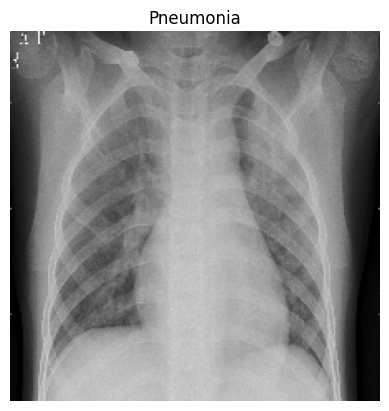

In [52]:
def load_and_preprocess_image(image_path):
    """Load and preprocess an image for visualization."""
    return cv2.resize(cv2.cvtColor(imread(image_path), cv2.COLOR_BGR2RGB), (224, 224))

# Randomly sample one image from the dataset
sampled_image = final_dataframe.sample(1).iloc[0]
processed_image = load_and_preprocess_image(sampled_image["file_path"])

# Display the sampled image
plt.imshow(processed_image)
plt.title(sampled_image["category"])
plt.axis("off")
plt.show()

Below cell takes 10-15 minutes to run

In [53]:
# Estimate noise levels for the sampled image
print("Noise estimates (per channel):", estimate_sigma(processed_image, channel_axis=2))
print("Average noise estimate:", estimate_sigma(processed_image, channel_axis=2, average_sigmas=True))

# Calculate noise levels for all images in the dataset
noise_levels = [estimate_sigma(load_and_preprocess_image(img_path), channel_axis=2) for img_path in final_dataframe["file_path"]]

Noise estimates (per channel): [3.3141137239263356, 3.3141137239263356, 3.3141137239263356]
Average noise estimate: 3.314113723926335


In [54]:
# Store noise levels in a DataFrame
noise_df = pd.DataFrame(data=noise_levels, columns=['Red', 'Green', 'Blue'])
noise_df['Overall'] = noise_df.mean(axis=1)

# Filter images with low noise levels
low_noise_images = noise_df[(noise_df['Red'] < 0.25) & (noise_df['Green'] < 0.25) & (noise_df['Blue'] < 0.25)]
low_noise_indices = low_noise_images.head(25).index



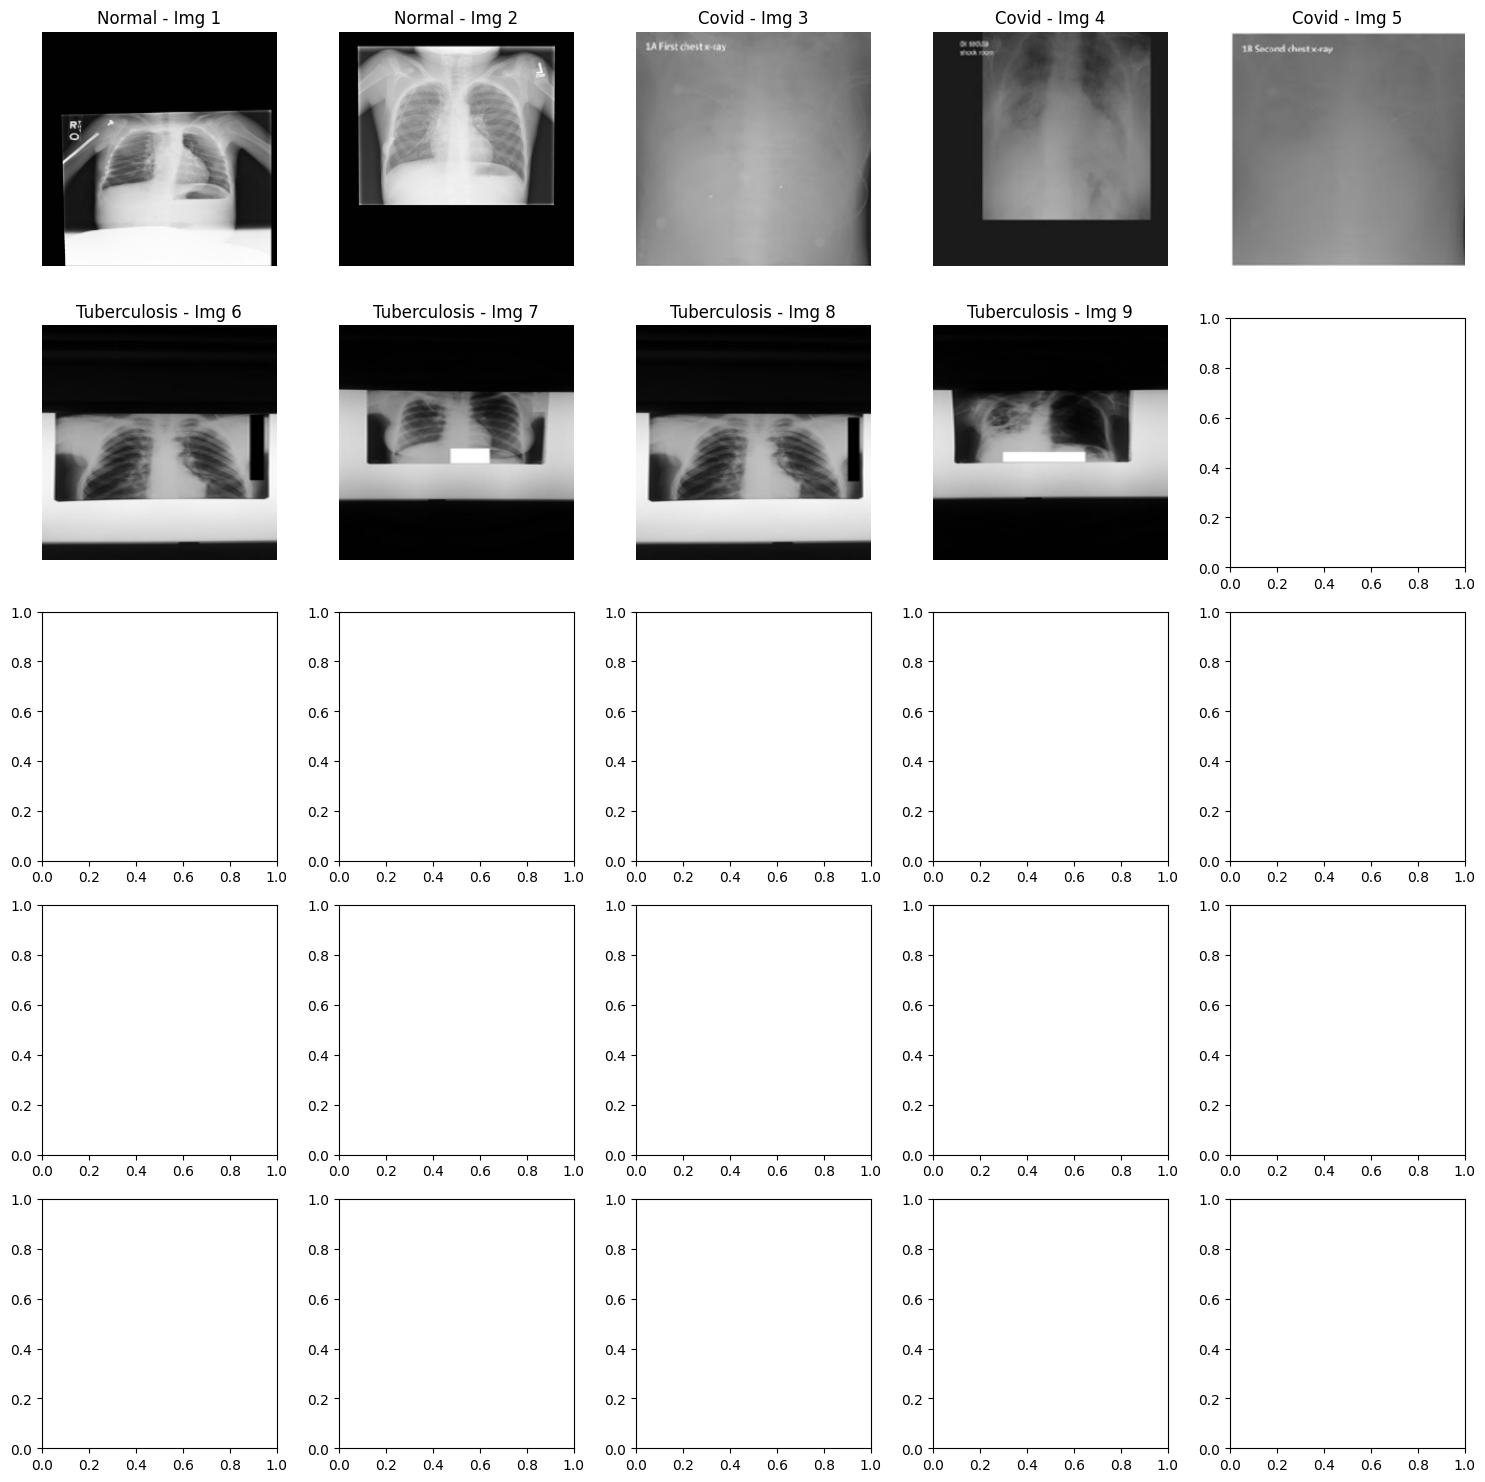

In [55]:
# Display a grid of low-noise images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for idx, img_idx in enumerate(low_noise_indices):
    ax = axes.flat[idx]
    ax.imshow(load_and_preprocess_image(final_dataframe["file_path"][img_idx]))
    ax.set_title(f'{final_dataframe["category"][img_idx]} - Img {idx + 1}')
    ax.axis("off")

plt.tight_layout()
plt.show()

In [56]:
# Print the number of rows in labeled_dataframe before dropping
print(f"Number of rows before dropping: {len(final_dataframe)}")

# Identify the indices of rows to drop
rows_to_drop = noise_df[noise_df['Overall'] < 0.25].index

# Print the number of rows being dropped
print(f"Number of rows being dropped: {len(rows_to_drop)}")

# Drop the rows from labeled_dataframe
final_dataframe.drop(rows_to_drop, axis=0, inplace=True)

# Print the number of rows in labeled_dataframe after dropping
print(f"Number of rows after dropping: {len(final_dataframe)}")

Number of rows before dropping: 20484
Number of rows being dropped: 9
Number of rows after dropping: 20475


In [57]:
# Count rows where noise levels for all channels (Red, Green, Blue) are below 0.25
low_noise_counts = noise_df[(noise_df['Red'] < 0.25) & (noise_df['Green'] < 0.25) & (noise_df['Blue'] < 0.25)].count()
print("Low noise counts (all channels):\n", low_noise_counts)

# Count rows where the overall noise level is below 0.25
overall_low_noise_counts = noise_df[noise_df['Overall'] < 0.25].count()
print("Low noise counts (overall):\n", overall_low_noise_counts)

# Merge rows where overall noise is low with rows where all channel noise is low
merged_df = noise_df[noise_df['Overall'] < 0.25].merge(
    noise_df[(noise_df['Red'] < 0.25) & (noise_df['Green'] < 0.25) & (noise_df['Blue'] < 0.25)],
    how='left',
    indicator=True
)

# Count rows where the merge result is not 'both' (i.e., rows that don't match both conditions)
non_matching_rows = len(merged_df[merged_df['_merge'] != 'both'])
print("Number of non-matching rows:", non_matching_rows)

# Drop rows from final_dataframe where overall noise is below 0.25
final_dataframe.drop(final_dataframe[noise_df['Overall'] < 0.25].index, axis=0, inplace=True)

Low noise counts (all channels):
 Red        9
Green      9
Blue       9
Overall    9
dtype: int64
Low noise counts (overall):
 Red        9
Green      9
Blue       9
Overall    9
dtype: int64
Number of non-matching rows: 0


/var/folders/r7/d0x7vphd32173gqlfx1tdzwr0000gn/T/ipykernel_7008/4251100980.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_dataframe.drop(final_dataframe[noise_df['Overall'] < 0.25].index, axis=0, inplace=True)


Below cell takes 10-15 mins to run

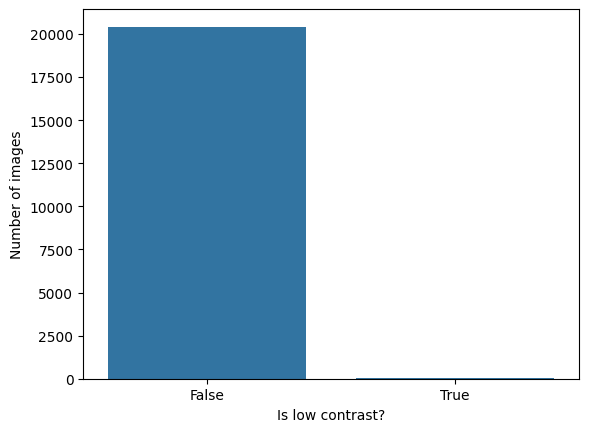

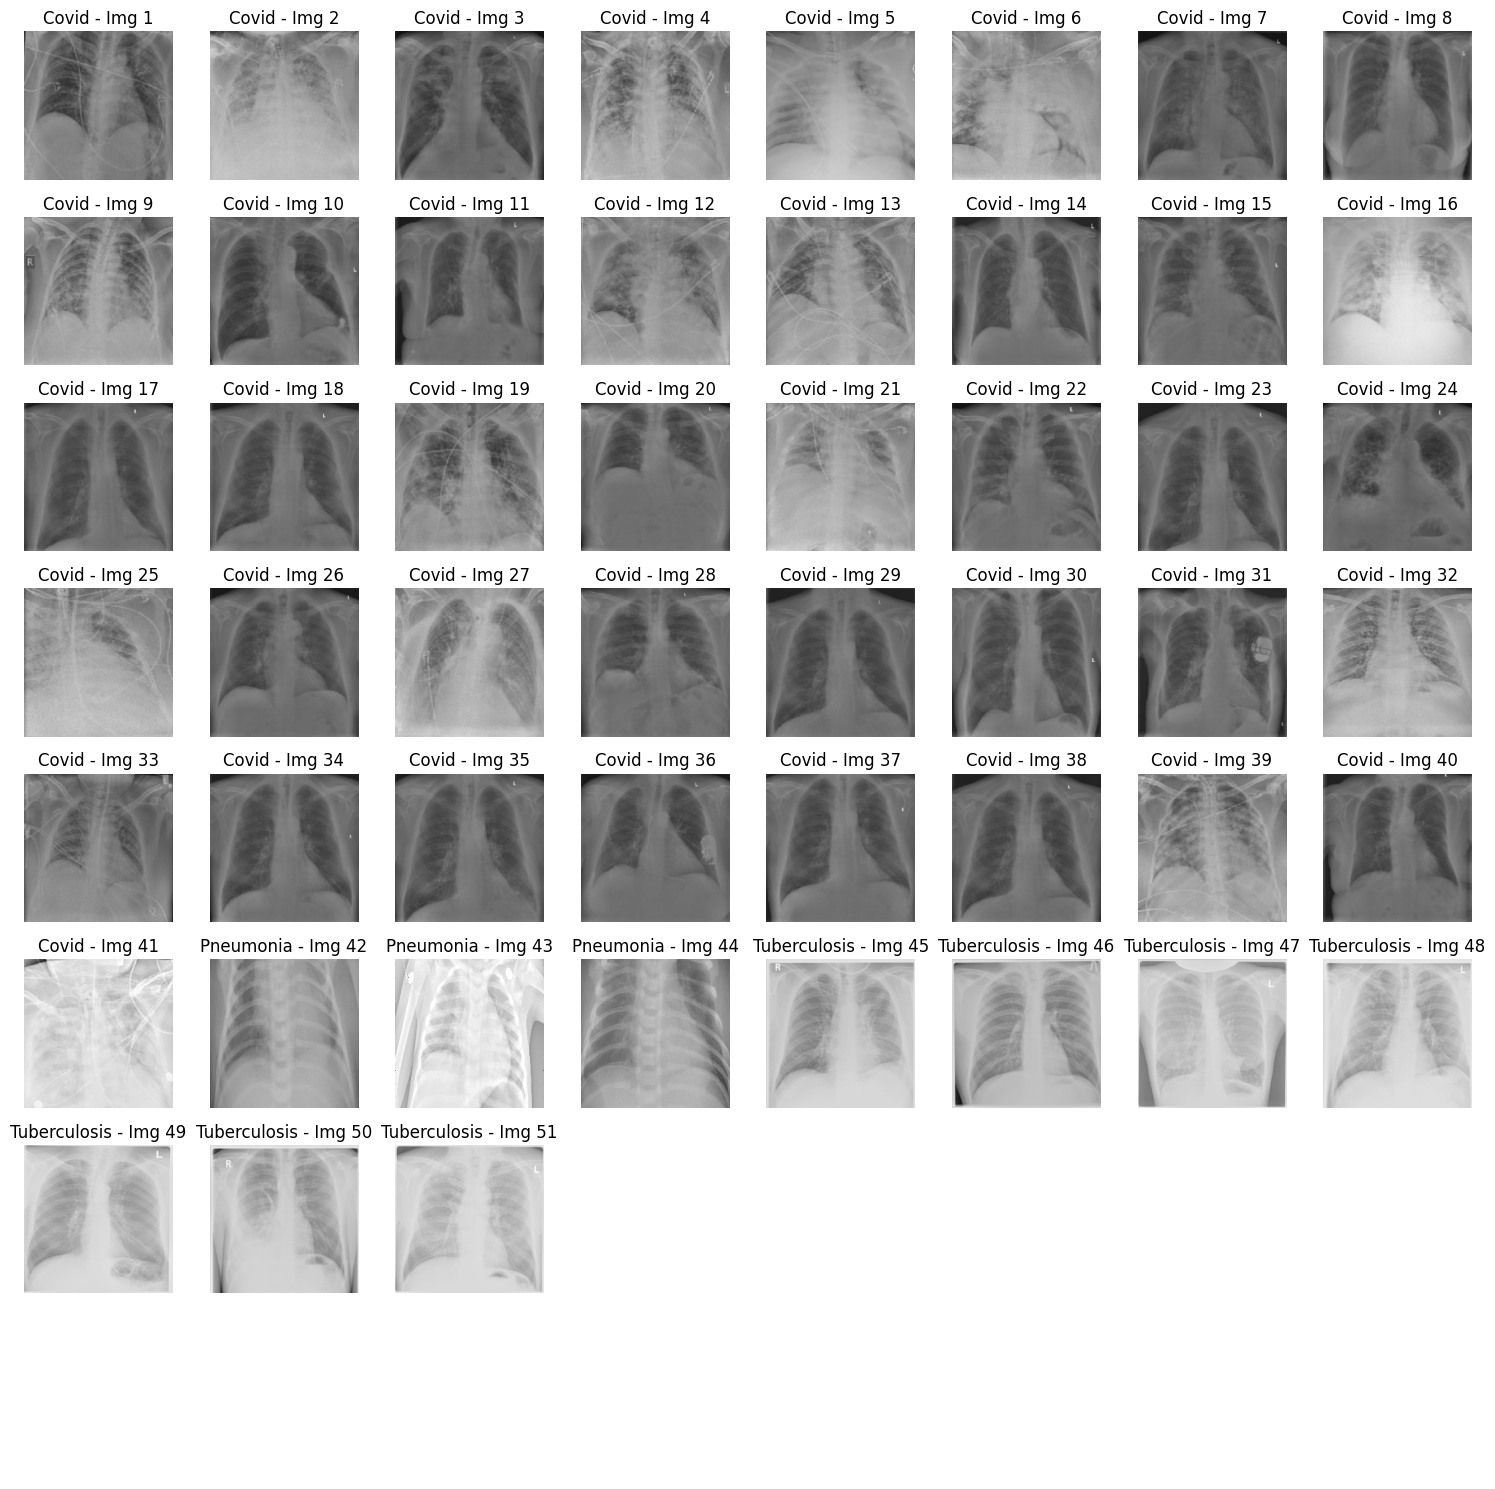

In [58]:
def is_low_contrast(image_path, fraction_threshold):
    """Check if an image is low contrast based on a given threshold."""
    return bool(exposure.is_low_contrast(load_and_preprocess_image(image_path), fraction_threshold=fraction_threshold))

# Add low contrast indicator column
final_dataframe['is_low_contrast'] = final_dataframe['file_path'].apply(is_low_contrast, fraction_threshold=0.2)

# Plot count of low contrast images
ax = sns.countplot(data=final_dataframe, x='is_low_contrast')
ax.set(xlabel='Is low contrast?', ylabel='Number of images')
plt.show()

# Display grid of low contrast images
fig, axes = plt.subplots(8, 8, figsize=(15, 15))
low_contrast_images = final_dataframe[final_dataframe["is_low_contrast"] == True]

for idx, ax in enumerate(axes.flat):
    if idx < len(low_contrast_images):
        current_row = low_contrast_images.iloc[idx]
        ax.imshow(load_and_preprocess_image(current_row['file_path']))
        ax.set_title(f"{current_row['category']} - Img {idx + 1}")
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

# Drop low contrast images and remove the column
final_dataframe.drop(final_dataframe[final_dataframe['is_low_contrast'] == True].index, axis=0, inplace=True)
final_dataframe.drop(columns=['is_low_contrast'], inplace=True)

First image exists: True
Second image exists: True


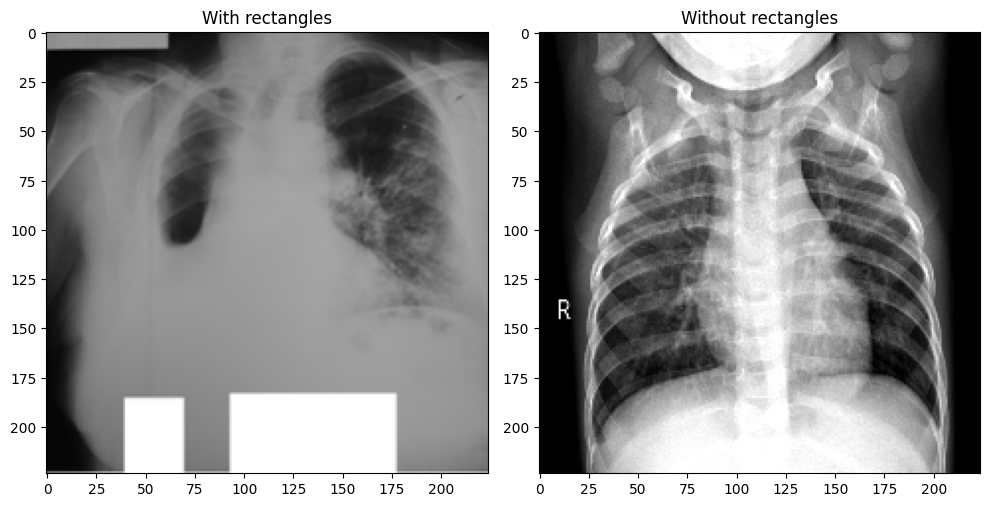

In [59]:
# Adjust paths according to your file structure
first_image_path = "/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Tuberculosis/Tuberculosis-239.png"
second_image_path = "/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset3/chest_xray/train/NORMAL/IM-0228-0001.jpeg"

# Check if the images exist
print("First image exists:", os.path.exists(first_image_path))
print("Second image exists:", os.path.exists(second_image_path))

# Load and resize the images
first_image = cv2.resize(cv2.imread(first_image_path), (224, 224))
second_image = cv2.resize(cv2.imread(second_image_path), (224, 224))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].set_title("With rectangles")
axes[0].imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB

# Display the second image
axes[1].set_title("Without rectangles")
axes[1].imshow(cv2.cvtColor(second_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB

# Show the plot
plt.tight_layout()
plt.show()

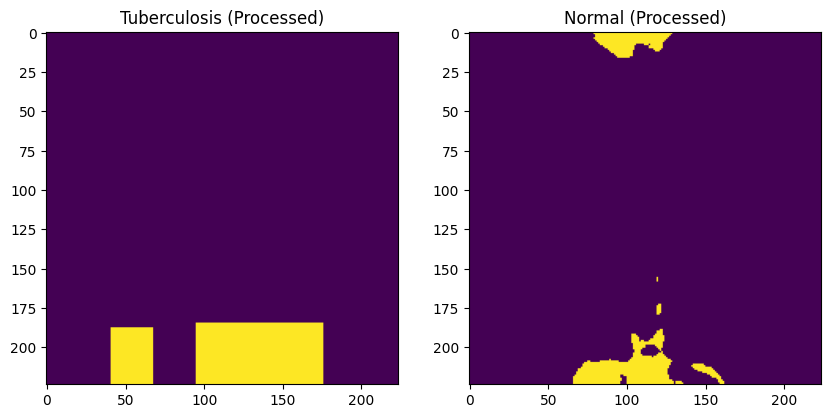

In [60]:
# Convert images to grayscale
tb_gray = cv2.cvtColor(first_image, cv2.COLOR_RGB2GRAY)
normal_gray = cv2.cvtColor(second_image, cv2.COLOR_RGB2GRAY)

# Create figure for comparison
fig, img_axes = plt.subplots(1, 2, figsize=(10,5))

# Process tuberculosis image
tb_blur = cv2.bilateralFilter(tb_gray, 1, 75, 75)
_, tb_thresh = cv2.threshold(tb_blur, 252, 255, cv2.THRESH_BINARY)
img_axes[0].set_title("Tuberculosis (Processed)")
img_axes[0].imshow(tb_thresh)

# Process normal image
normal_blur = cv2.bilateralFilter(normal_gray, 9, 75, 75)
_, normal_thresh = cv2.threshold(normal_blur, 252, 255, cv2.THRESH_BINARY)
img_axes[1].set_title("Normal (Processed)")
img_axes[1].imshow(normal_thresh)

plt.show()

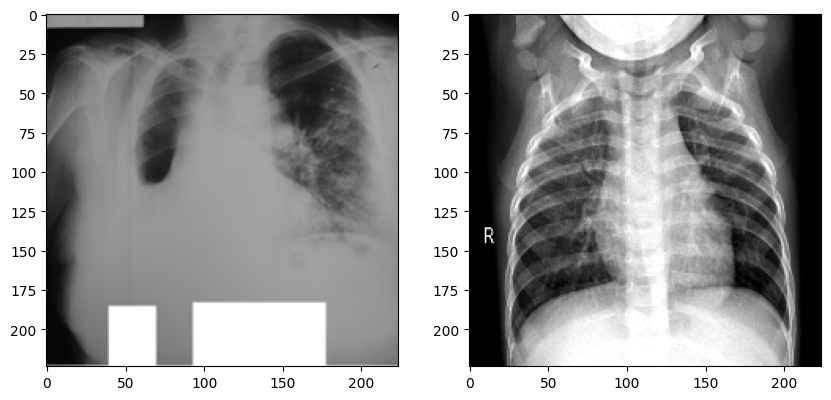

In [61]:
# Find contours in both images
tb_contours, _ = cv2.findContours(tb_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
normal_contours, _ = cv2.findContours(normal_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Setup display
fig, contour_axes = plt.subplots(1, 2, figsize=(10,5))
MIN_AREA = 200  # Minimum area threshold for rectangle detection

def draw_detected_rectangles(image, contours, axis_index):
    """Draws rectangles around detected contours that meet area threshold"""
    contour_axes[axis_index].imshow(image)
    
    for contour in contours:
        # Approximate polygon and check if quadrilateral
        perimeter = cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
        
        if len(polygon) == 4:
            # Extract rectangle coordinates
            x, y = polygon[0][0][0], polygon[0][0][1]
            width = polygon[1][0][0] - x
            height = polygon[2][0][1] - y
            
            # Only draw if meets minimum area
            if width * height >= MIN_AREA:
                cv2.rectangle(image, (x, y), (x+width, y+height), (0, 0, 255), 2)

# Process and display both images
draw_detected_rectangles(first_image, tb_contours, 0)
draw_detected_rectangles(second_image, normal_contours, 1)

plt.show()

In [62]:
def contains_rectangle(img_path):
    """Check if image contains rectangular regions exceeding area threshold"""
    # Image loading and preprocessing
    raw_img = imread(img_path)
    resized_img = cv2.resize(raw_img, (224, 224))
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    
    # Image processing
    smoothed_img = cv2.bilateralFilter(gray_img, 1, 75, 75)
    _, thresholded_img = cv2.threshold(smoothed_img, 252, 255, cv2.THRESH_BINARY)
    
    # Contour detection
    detected_contours, _ = cv2.findContours(
        thresholded_img, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Rectangle verification
    for contour in detected_contours:
        contour_perimeter = cv2.arcLength(contour, True)
        polygon_approx = cv2.approxPolyDP(contour, 0.05 * contour_perimeter, True)
        
        if len(polygon_approx) == 4:  # Check if quadrilateral
            pt1, pt2, pt3, pt4 = polygon_approx
            width = pt4[0][0] - pt1[0][0]
            height = pt2[0][1] - pt1[0][1]
            bbox_area = width * height
            
            if bbox_area >= MIN_AREA:
                return True
                
    return False

Below cell takes 10-15 mins to run

In [63]:
# Apply rectangle detection to all images
final_dataframe["contains_rectangle"] = final_dataframe["file_path"].apply(contains_rectangle)

In [64]:
# Count rectangle occurrences by category
rectangle_counts = (final_dataframe[final_dataframe["contains_rectangle"] == True]
                  .groupby("category").size()
                  .reset_index(name="count")
                  .rename(columns={"category": "label"}))


rectangle_counts

,label,count
0,Covid,33
1,Normal,4
2,Tuberculosis,190


In [65]:
def display_rectangle_samples(category, grid_size=3, show_labels=False):
    """
    Display grid of images containing rectangles for specified category
    
    Args:
        category (str): Image category to display (e.g., 'Normal', 'Tuberculosis')
        grid_size (int): Size of grid (grid_size x grid_size)
        show_labels (bool): Whether to show image labels
    """
    # Create figure and get matching samples
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    rect_samples = final_dataframe[
        (final_dataframe["contains_rectangle"] == True) & 
        (final_dataframe["category"] == category)
    ]
    
    # Display each sample image
    for idx, ax in zip(range(len(rect_samples)), axes.flat):
            sample = rect_samples.iloc[idx]
            plt.subplot(grid_size,grid_size,idx+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)

            ax.imshow(load_and_preprocess_image(sample['file_path']))
            
            if not show_labels:
                ax.xaxis.label.set_text(f"{sample['category']} - Sample {idx + 1}")
            
    plt.tight_layout()
    plt.show()

In [66]:
# # Display sample grids for different categories
# display_rectangle_samples(category="Normal", grid_size=4)
# display_rectangle_samples(category="Tuberculosis", grid_size=14, show_labels=True)
# display_rectangle_samples(category="Covid", grid_size=6)

# Count images to be removed
num_dropped = final_dataframe["contains_rectangle"].sum()
print(f"Dropping {int(num_dropped)} images with rectangles")

# Remove images with rectangles
final_dataframe.drop(
    final_dataframe[final_dataframe["contains_rectangle"] == True].index,
    axis=0,
    inplace=True
)

# Remove the detection column
final_dataframe.drop(columns=['contains_rectangle'], inplace=True)

# Print remaining count
print(f"Remaining images: {len(final_dataframe)}")

Dropping 227 images with rectangles
Remaining images: 20197


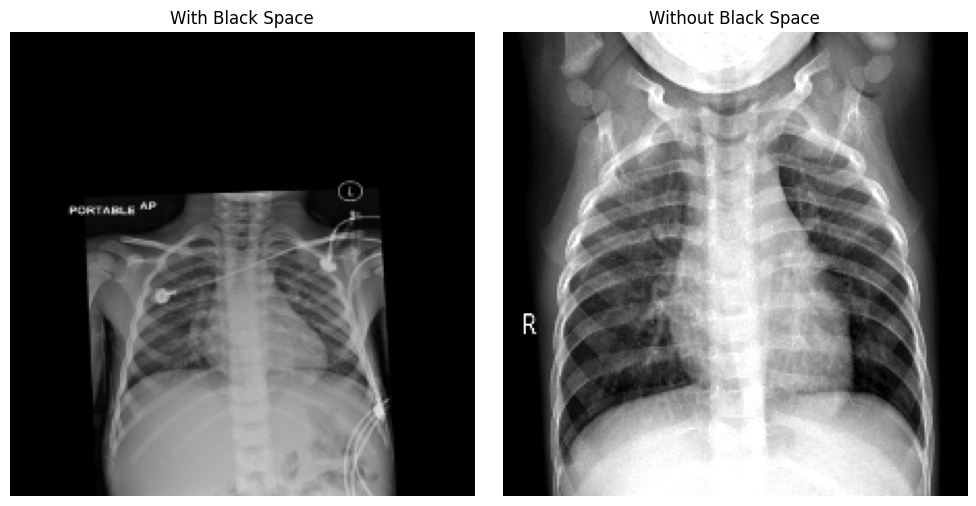

In [67]:
# Load and resize images
normal_sample = cv2.resize(cv2.imread(r"/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset2/all_images/Normal/Normal-3323.png"), (224, 224))
chestxray_sample = cv2.resize(cv2.imread(r"/Users/vansh11/Downloads/CMPT 340/PROJECT/2025_1_project_22/src/RawData/dataset3/chest_xray/train/NORMAL/IM-0228-0001.jpeg"), (224, 224))

# Create comparison plot
plt.figure(figsize=(10, 5))

# Display first image (with black space)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(normal_sample, cv2.COLOR_BGR2RGB))
plt.title("With Black Space")
plt.axis('off')

# Display second image (without black space)
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(chestxray_sample, cv2.COLOR_BGR2RGB))
plt.title("Without Black Space")
plt.axis('off')

plt.tight_layout()
plt.show()

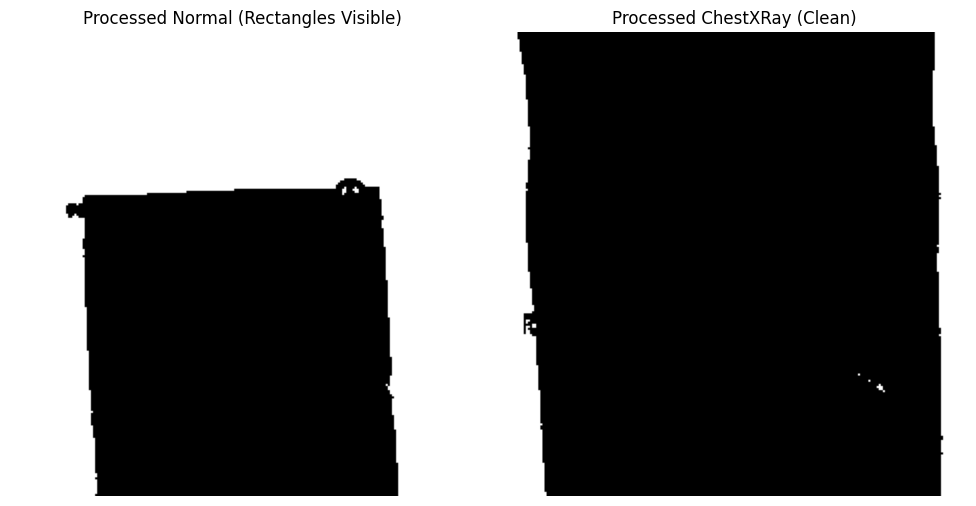

In [68]:
# Convert and invert images
inverted_normal = cv2.cvtColor(cv2.bitwise_not(normal_sample), cv2.COLOR_RGB2GRAY)
inverted_chestxray = cv2.cvtColor(cv2.bitwise_not(chestxray_sample), cv2.COLOR_RGB2GRAY)

# Create processing figure
plt.figure(figsize=(10, 5))

# Process and display first image
plt.subplot(1, 2, 1)
processed_normal = cv2.bilateralFilter(inverted_normal, 1, 75, 75)
_, binary_normal = cv2.threshold(processed_normal, 252, 255, cv2.THRESH_BINARY)
plt.imshow(binary_normal, cmap='gray')
plt.title("Processed Normal (Rectangles Visible)")
plt.axis('off')

# Process and display second image
plt.subplot(1, 2, 2)
processed_chestxray = cv2.bilateralFilter(inverted_chestxray, 1, 75, 75)
_, binary_chestxray = cv2.threshold(processed_chestxray, 252, 255, cv2.THRESH_BINARY)
plt.imshow(binary_chestxray, cmap='gray')
plt.title("Processed ChestXRay (Clean)")
plt.axis('off')

plt.tight_layout()
plt.show()

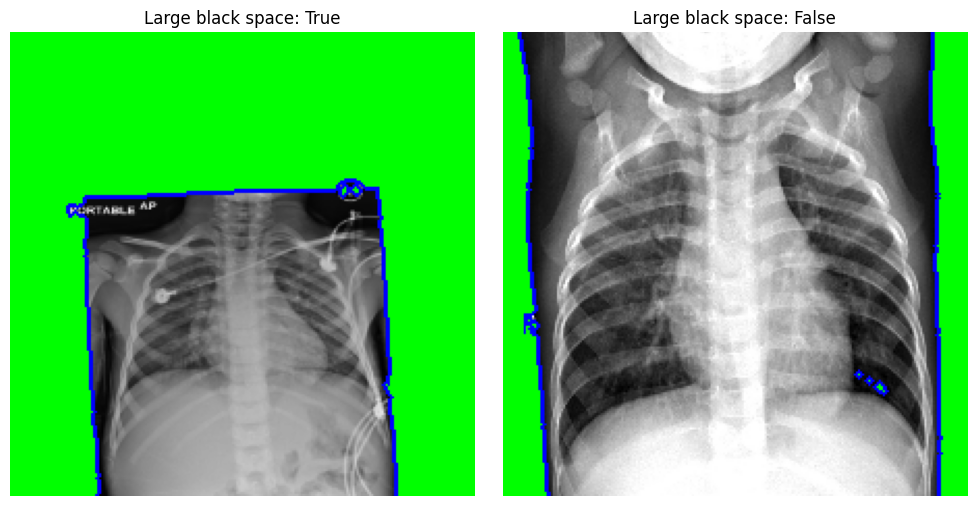

In [69]:
# Find contours in both binary images
normal_contours, _ = cv2.findContours(binary_normal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
chestxray_contours, _ = cv2.findContours(binary_chestxray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Set area thresholds
MIN_CONTOUR_AREA = 13000  # Minimum area for single contour
MIN_TOTAL_AREA = 18000    # Minimum combined area of all contours

# Create visualization figure
plt.figure(figsize=(10, 5))

def analyze_black_space(original_img, contours, subplot_pos):
    """Analyze and visualize black space in X-ray images"""
    img_copy = original_img.copy()
    has_large_space = False
    total_area = 0
    
    # Process all contours
    for cnt in contours:
        area = cv2.contourArea(cnt)
        total_area += area
        
        # Draw contour visualization
        cv2.drawContours(img_copy, [cnt], -1, (0, 0, 255), 3)
        cv2.fillPoly(img_copy, pts=[cnt], color=(0, 255, 0))
        
        # Check individual contour size
        if area > MIN_CONTOUR_AREA:
            has_large_space = True
    
    # Check combined contour area
    if total_area > MIN_TOTAL_AREA:
        has_large_space = True
    
    # Display results
    plt.subplot(1, 2, subplot_pos)
    plt.imshow(img_copy)
    plt.title(f"Large black space: {has_large_space}")
    plt.axis('off')

# Analyze both images
analyze_black_space(normal_sample, normal_contours, 1)
analyze_black_space(chestxray_sample, chestxray_contours, 2)

plt.tight_layout()
plt.show()

In [70]:
def detect_dark_regions(image_path):
    """Detects significant dark regions in an image"""
    # Image loading and preprocessing
    original_img = imread(image_path)
    resized_img = cv2.resize(original_img, (224, 224))
    rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    
    # Image processing
    inverted_img = cv2.bitwise_not(gray_img)
    denoised_img = cv2.bilateralFilter(inverted_img, 1, 75, 75)
    _, binary_mask = cv2.threshold(denoised_img, 252, 255, cv2.THRESH_BINARY)
    
    # Contour analysis
    dark_contours, _ = cv2.findContours(
        binary_mask,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )
    
    total_dark_area = 0
    has_large_dark_region = False
    
    for contour in dark_contours:
        contour_area = cv2.contourArea(contour)
        total_dark_area += contour_area
        
        if contour_area > MIN_CONTOUR_AREA:
            has_large_dark_region = True
            
    if total_dark_area > MIN_TOTAL_AREA:
        has_large_dark_region = True
        
    return has_large_dark_region


In [71]:
# Apply black space detection to all images
final_dataframe["contains_dark_regions"] = final_dataframe["file_path"].apply(detect_dark_regions)

# Count and display results by category
dark_region_counts = (final_dataframe[final_dataframe["contains_dark_regions"]]
                     .groupby("category").size()
                     .reset_index(name="count")
                     .rename(columns={"category": "label"}))
print("Images with significant dark regions by category:")
print(dark_region_counts)

Images with significant dark regions by category:
          label  count
0         Covid      8
1        Normal     60
2     Pneumonia      3
3  Tuberculosis     12


In [72]:
# Track number of images before removal
initial_count = len(final_dataframe)

# Remove images with dark regions
images_with_dark_regions = final_dataframe[final_dataframe["contains_dark_regions"]]
final_dataframe.drop(images_with_dark_regions.index, axis=0, inplace=True)

# Remove the detection column
final_dataframe.drop(columns=['contains_dark_regions'], inplace=True)

# Print removal summary
print(f"Removed {len(images_with_dark_regions)} images with dark regions")
print(f"Remaining images: {len(final_dataframe)} (from initial {initial_count})")
print("Category distribution after removal:")
print(final_dataframe["category"].value_counts())

Removed 83 images with dark regions
Remaining images: 20114 (from initial 20197)
Category distribution after removal:
category
Normal          10957
Pneumonia        6030
Tuberculosis     1675
Covid            1452
Name: count, dtype: int64


In [73]:
# Remove dataset 2 entries
final_dataframe.drop(final_dataframe[final_dataframe["dataset_source"] == 2].index, inplace=True)

# Calculate and display label distribution
category_distribution = (final_dataframe["category"]
                        .value_counts()
                        .rename_axis('category')
                        .reset_index(name='count'))
category_balance = dict(zip(category_distribution["category"], category_distribution["count"]))

# Calculate normal images per dataset
normal_distribution = (final_dataframe[final_dataframe["category"] == "Normal"]
                      ["dataset_source"]
                      .value_counts()
                      .rename_axis('dataset')
                      .reset_index(name='count'))
normal_balance = dict(zip(normal_distribution["dataset"], normal_distribution["count"]))

# Print formatted results
print("\nCurrent Dataset Balance:")
print(f"{'Category':<12} {'Count':>8}")
for category, count in sorted(category_balance.items()):
    print(f"{category:<12} {count:>8}")

print("\nNormal Images by Dataset:")
print(f"{'Dataset':<8} {'Count':>8}")
for dataset, count in sorted(normal_balance.items()):
    print(f"{dataset:<8} {count:>8}")


Current Dataset Balance:
Category        Count
Covid            1452
Normal          10893
Pneumonia        6030
Tuberculosis     1675

Normal Images by Dataset:
Dataset     Count
0            9226
1            1667


In [74]:
# Calculate required balancing
normal_count = category_balance["Normal"]
pneumonia_count = category_balance["Pneumonia"]
normal_to_remove = normal_count - pneumonia_count

# Calculate removal distribution across datasets
removal_distribution = {}
for dataset_id, count in normal_balance.items():
    removal_distribution[dataset_id] = int(np.floor((count / normal_count) * normal_to_remove))

# Handle any remainder
if normal_to_remove > sum(removal_distribution.values()):
    primary_dataset = min(normal_balance.keys())  # Use smallest dataset ID for remainder
    removal_distribution[primary_dataset] += normal_to_remove - sum(removal_distribution.values())

print("Normal images to remove per dataset:")
print(removal_distribution)

# Execute balanced removal
for dataset_id, remove_count in removal_distribution.items():
    if remove_count > 0:
        normal_samples = final_dataframe[
            (final_dataframe["dataset_source"] == dataset_id) & 
            (final_dataframe["category"] == "Normal")
        ]
        final_dataframe.drop(normal_samples.index[:remove_count], inplace=True)

# Verify new balance
new_balance = final_dataframe["category"].value_counts()
print("\nNew class balance:")
print(new_balance)

Normal images to remove per dataset:
{0: 4119, 1: 744}

New class balance:
category
Normal          6030
Pneumonia       6030
Tuberculosis    1675
Covid           1452
Name: count, dtype: int64


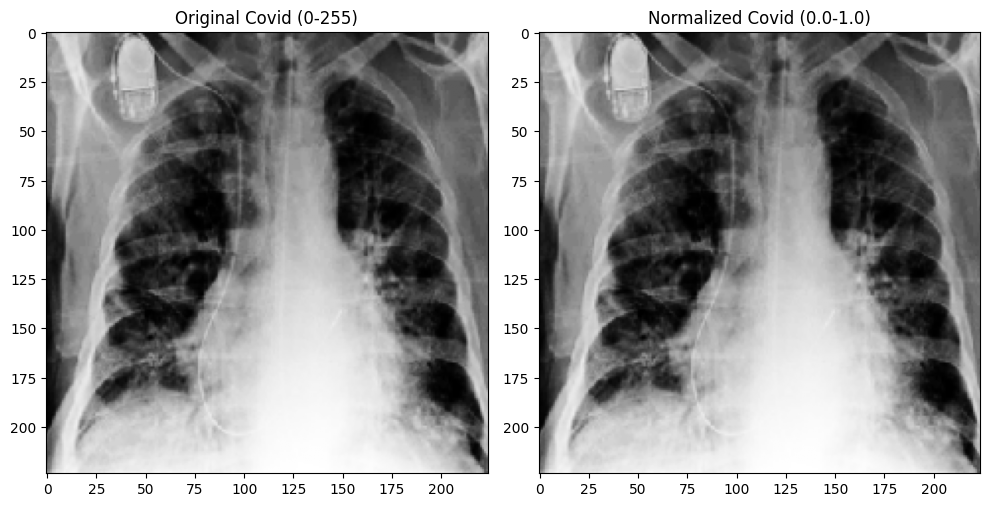

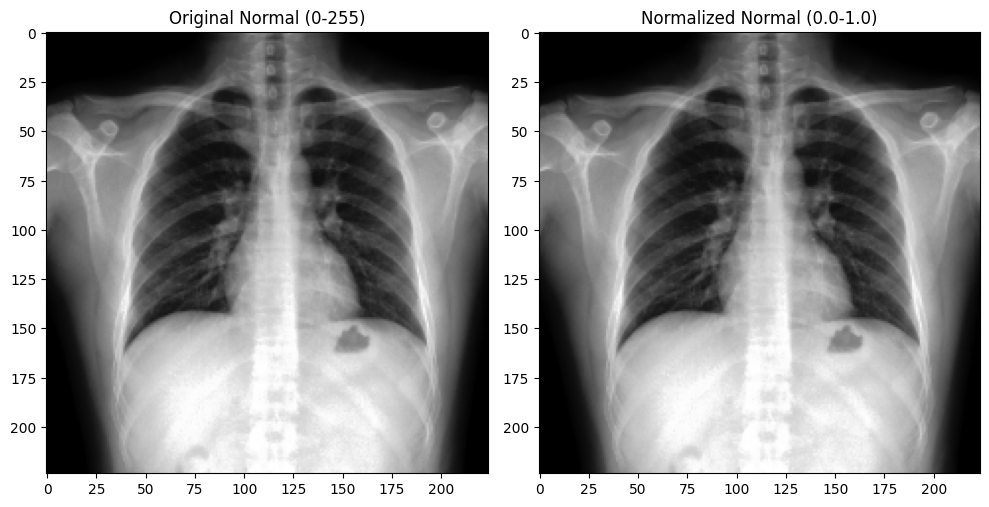

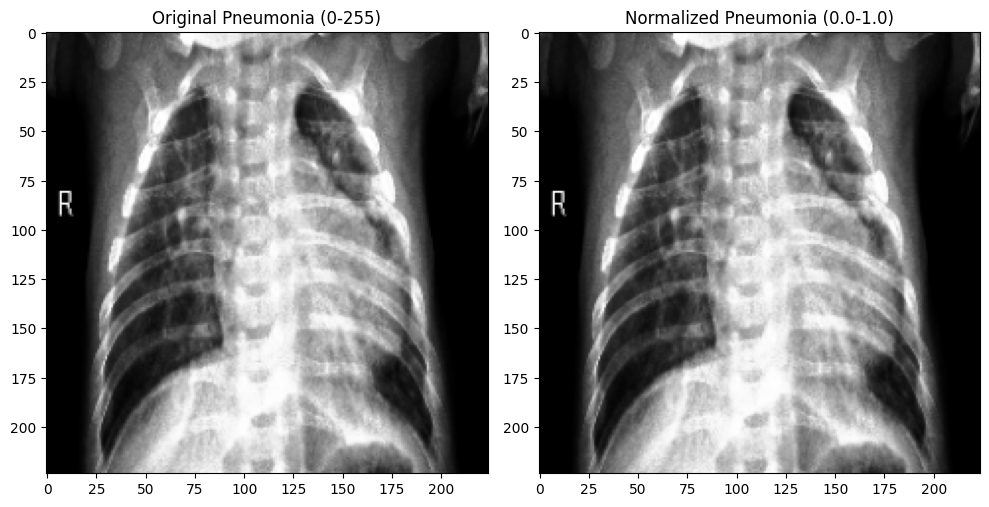

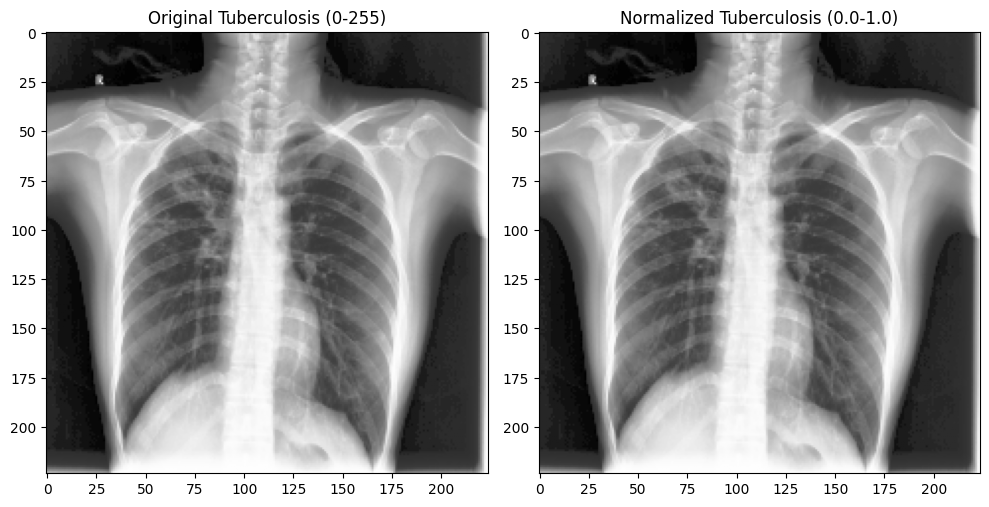

In [75]:
def normalize_image(image):
    """Normalize image pixel values to [0.0, 1.0] range"""
    return cv2.normalize(image, None, 0.0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_64FC1)

def load_grayscale_image(path):
    """Load and preprocess image as grayscale"""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (224, 224))

# Visualize normalization for each category
for category, group_df in final_dataframe.groupby("category"):
    sample = group_df.sample(1).iloc[0]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Process and display original image
    gray_img = load_grayscale_image(sample['file_path'])
    equalized = cv2.equalizeHist(gray_img)
    axes[0].set_title(f"Original {category} (0-255)")
    axes[0].imshow(equalized, cmap='gray')
    
    # Process and display normalized image
    normalized = normalize_image(equalized)
    axes[1].set_title(f"Normalized {category} (0.0-1.0)")
    axes[1].imshow(normalized, cmap='gray')
    
    plt.tight_layout()
    plt.show()

# Apply preprocessing pipeline
final_dataframe['processed_image'] = (
    final_dataframe['file_path']
    .apply(load_grayscale_image)
    .apply(cv2.equalizeHist)
    .apply(normalize_image)
)

In [77]:
# Create train-test split (80-20)
train_df, test_df = train_test_split(
    final_dataframe, 
    test_size=0.2, 
    random_state=42,
    stratify=final_dataframe["category"]
)

# Further split train into train-validation (75-25 split of train, meaning 60-20 overall)
train_df, val_df = train_test_split(
    train_df,
    test_size=0.25,  # 25% of training data -> 20% of total data
    random_state=42,
    stratify=train_df["category"]
)

# Define dataset paths
dataset_path = "preprocessed_data"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
val_path = os.path.join(dataset_path, "val")

# Clean and create directory structure
shutil.rmtree(dataset_path, ignore_errors=True)

for category in final_dataframe["category"].unique():
    os.makedirs(os.path.join(train_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_path, category), exist_ok=True)
    os.makedirs(os.path.join(val_path, category), exist_ok=True)  # Create validation directory

def save_processed_image(row, save_path):
    """Save preprocessed image with metadata in filename."""
    img_id = f"{row.name}_{row['dataset_source']}"
    filename = os.path.join(save_path, row['category'], f"{img_id}.png")
    
    # Convert normalized image back to 8-bit (0-255) for saving
    img_8bit = (row["processed_image"] * 255).astype(np.uint8)
    
    cv2.imwrite(filename, img_8bit)
    return filename

# Save images to respective directories
print("Saving training images...")
train_df.apply(lambda row: save_processed_image(row, train_path), axis=1)

print("Saving test images...")
test_df.apply(lambda row: save_processed_image(row, test_path), axis=1)

print("Saving validation images...")
val_df.apply(lambda row: save_processed_image(row, val_path), axis=1)

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test sets (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
print("\nCreating data generators...")
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,  # Adjust batch size for efficiency
    class_mode='categorical',
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Important for consistent evaluation
)

# Verify class distributions
print("\nClass distributions:")
print("Training:", {k: v for k, v in zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes))})
print("Validation:", {k: v for k, v in zip(val_generator.class_indices.keys(), np.bincount(val_generator.classes))})
print("Test:", {k: v for k, v in zip(test_generator.class_indices.keys(), np.bincount(test_generator.classes))})

Saving training images...
Saving test images...
Saving validation images...

Creating data generators...
Found 9111 images belonging to 4 classes.
Found 3038 images belonging to 4 classes.
Found 3038 images belonging to 4 classes.

Class distributions:
Training: {'Covid': 870, 'Normal': 3618, 'Pneumonia': 3618, 'Tuberculosis': 1005}
Validation: {'Covid': 291, 'Normal': 1206, 'Pneumonia': 1206, 'Tuberculosis': 335}
Test: {'Covid': 291, 'Normal': 1206, 'Pneumonia': 1206, 'Tuberculosis': 335}
